# Problem statement

The objective is to cluster the customers of an e-commerce platform into distinct groups based on their purchasing behavior.

The dataset contains the following columns:

- InvoiceNo (integer)
- StockCode (string)
- Description (string)
- Quantity (integer)
- InvoiceDate (date)
- UnitPrice (decimal)
- CustomerID (integer)
- Country (string)

By analyzing the TotalAmount spent and TotalTransactions made by each customer, the company aims to identify different customer segments for targeted marketing strategies, personalized product offerings, and improved customer service.

The clustering process involves data preprocessing, feature engineering, outlier detection and removal, data scaling, and optimal cluster determination through both the Elbow Method and Silhouette Score, culminating in the application of K-Means clustering to categorize customers into meaningful segments.

The notebook contains 6 exercises in total:

* [Exercise 1](#ex_1)
* [Exercise 2](#ex_2)
* [Exercise 3](#ex_3)
* [Exercise 4](#ex_4)
* [Exercise 5](#ex_5)
* [Exercise 6](#ex_6)

In [2]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
#from sklearn_extra.cluster import KMeansExtra

# Step 1: Load the Dataset
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('clustering-data.csv', encoding='latin1')

Saving clustering-data.csv to clustering-data.csv


Shape of the DataFrame: (541909, 8)

First few rows of the DataFrame:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Column names and data types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     objec

<ipython-input-3-f690cc439240>:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_segmentation['TotalAmount'], df_segmentation['TotalTransactions']], labels=['TotalAmount', 'TotalTransactions'])


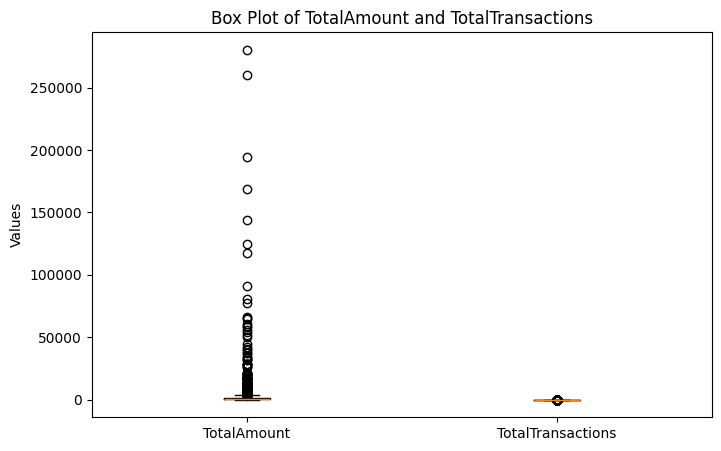

Shape of DataFrame after removing outliers: (3912, 2)


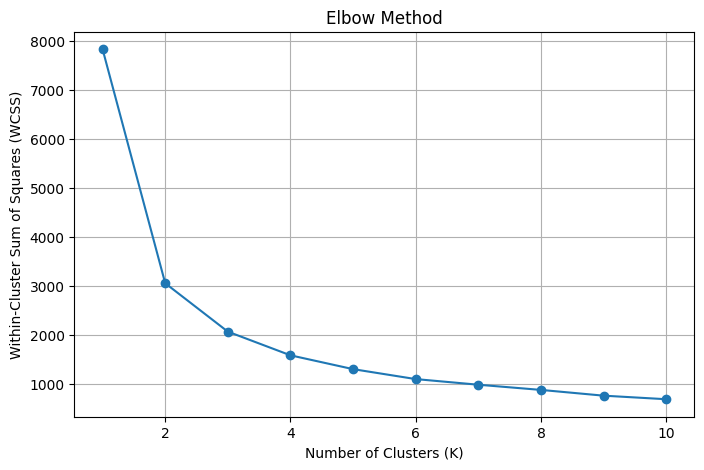

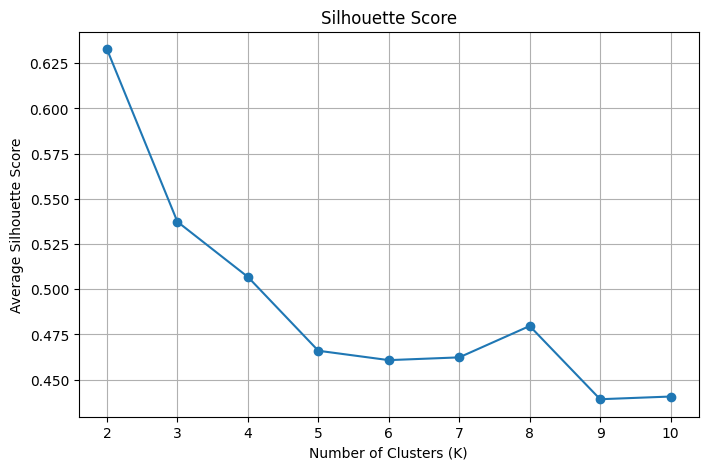

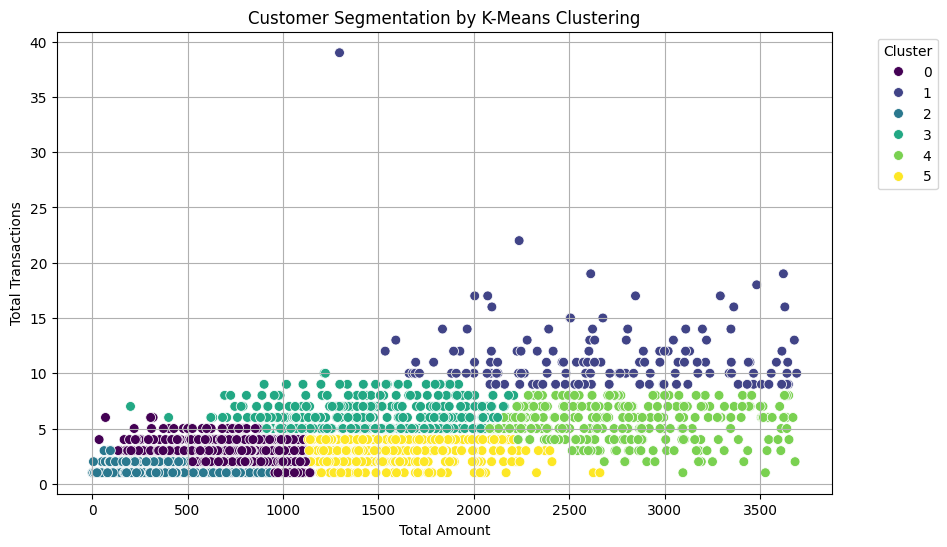

In [3]:
# Step 2: Inspect the Data
print("Shape of the DataFrame:", df.shape)
print("\nFirst few rows of the DataFrame:")
print(df.head())
print("\nColumn names and data types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Step 3: Summary Statistics
summary_stats = df.describe(include='all')
print("\nSummary Statistics:")
print(summary_stats)

# Step 4: Data Preprocessing
df_cleaned = df.dropna(subset=['CustomerID'])
df_cleaned = df_cleaned[(df_cleaned['Quantity'] >= 0) & (df_cleaned['UnitPrice'] >= 0)]
columns_to_drop = ['StockCode', 'InvoiceDate', 'Description', 'Country']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

# Step 5: Feature Engineering
df_cleaned['Amount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
df_total_amount = df_cleaned.groupby('CustomerID')['Amount'].sum().reset_index()
df_total_amount.rename(columns={'Amount': 'TotalAmount'}, inplace=True)
df_total_transactions = df_cleaned.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
df_total_transactions.rename(columns={'InvoiceNo': 'TotalTransactions'}, inplace=True)
df_segmentation = pd.merge(df_total_amount, df_total_transactions, on='CustomerID')

# Step 6: Checking for Outliers
df_segmentation.drop('CustomerID', axis=1, inplace=True)
plt.figure(figsize=(8, 5))
plt.boxplot([df_segmentation['TotalAmount'], df_segmentation['TotalTransactions']], labels=['TotalAmount', 'TotalTransactions'])
plt.title('Box Plot of TotalAmount and TotalTransactions')
plt.ylabel('Values')
plt.show()

# Step 7: Removing Outliers from TotalAmount column
Q1 = df_segmentation['TotalAmount'].quantile(0.25)
Q3 = df_segmentation['TotalAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_segmentation = df_segmentation[(df_segmentation['TotalAmount'] >= lower_bound) & (df_segmentation['TotalAmount'] <= upper_bound)]
print("Shape of DataFrame after removing outliers:", df_segmentation.shape)

# Step 8: Data Scaling using Standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_segmentation)
df_scaled = pd.DataFrame(df_scaled, columns=df_segmentation.columns)

# Step 9: Finding Optimal Number of Clusters - Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Step 10: Finding Optimal Number of Clusters - Silhouette Score Elbow Method
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)
plt.show()

# Step 11: Customer Segmentation K-Means Clustering with 6 Clusters
num_clusters = 6
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(df_scaled)
df_segmentation['Cluster'] = kmeans_model.labels_

# Step 12: Visualization of Clustering Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalAmount', y='TotalTransactions', hue='Cluster', data=df_segmentation, palette='viridis', s=50)
plt.xlabel('Total Amount')
plt.ylabel('Total Transactions')
plt.title('Customer Segmentation by K-Means Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


<a name="ex_1"></a>
# Exercise 1: Understanding the Importance of Removing Outliers

**Question**: In the context of data preprocessing, at the step mentioned in regarding the removal of outliers, explain why it is critical to remove outliers before training a machine learning model. Discuss the potential impacts of outliers on model performance and accuracy.

**Answer**:

**1. Impact on Centroid Calculation in K-Means**
K-Means clustering relies on centroids that represent the mean of data points in each cluster. Outliers can skew these centroids, leading to:

Poorly defined clusters.
Incorrect assignments of data points.
Reduced interpretability of clusters.

**2. Distortion of Distance-Based Metrics **
Since K-Means clustering depends on Euclidean distance, extreme outliers increase distances, causing:

Clusters to become less compact.
Irregular cluster shapes.
Higher variance in cluster sizes.

**3. Negative Effect on Model Stability & Convergence**

Outliers can cause the K-Means algorithm to take more iterations to converge.
Some outliers might form separate clusters, reducing the effectiveness of the segmentation.

**4. Computational Inefficiency**

Clustering large datasets with outliers requires more computation.
Removing outliers reduces unnecessary complexity and speeds up training.
Best Practice: Using IQR for Outlier Removal
In the script, Interquartile Range (IQR) is used to filter out extreme values in the TotalAmount column: [ IQR = Q3 - Q1 ] [ Lower\ Bound = Q1 - 1.5 \times IQR ] [ Upper\ Bound = Q3 + 1.5 \times IQR ]

This ensures that data remains representative while eliminating extreme variations.




<a name="ex_2"></a>
# Exercise 2: Exploring Alternative Scaling Techniques

**Question**: The notebook utilizes StandardScaler() for feature scaling. Identify at least one alternative scaling method that could be used in place of StandardScaler(). Implement this alternative method in the notebook and present the results of scaling the dataframe. Briefly compare the outcomes between the two scaling methods.

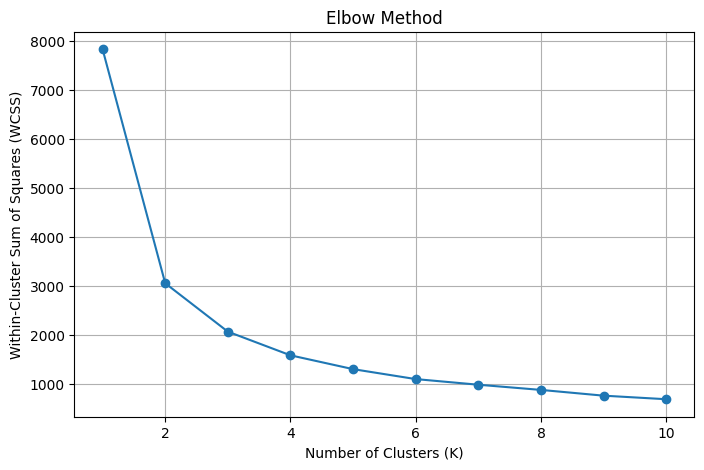

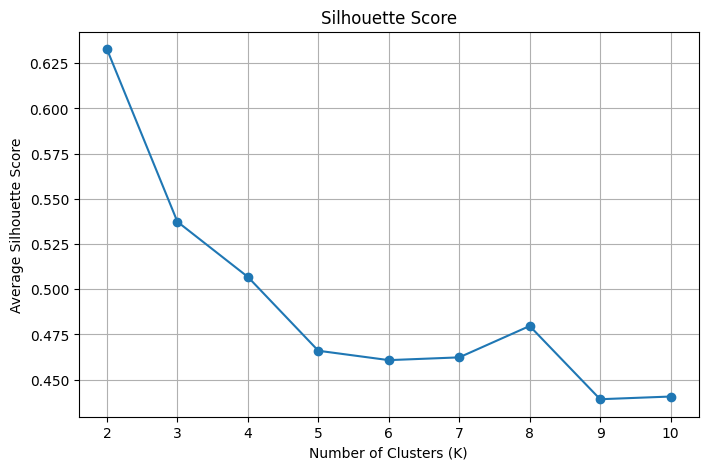

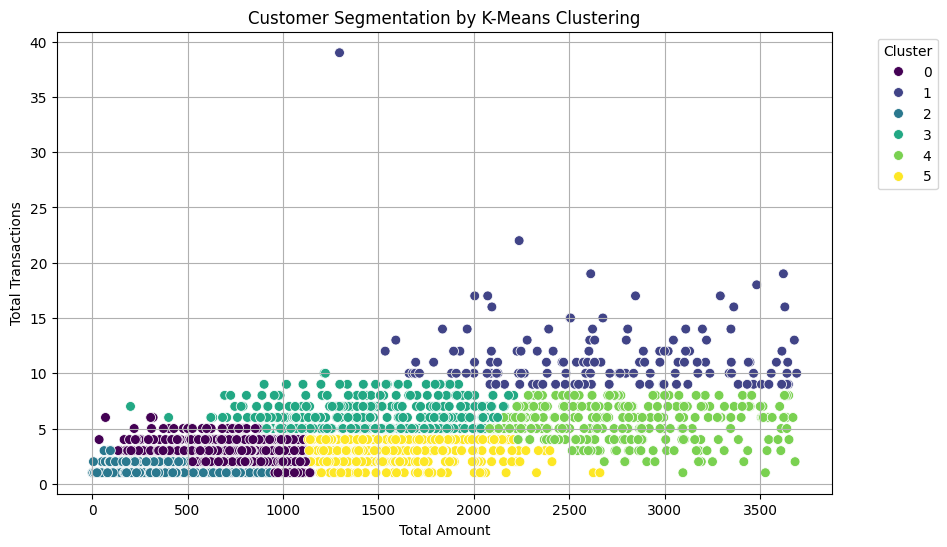

In [4]:
from sklearn.preprocessing import MinMaxScaler


# Step 8: Data Scaling using Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = minmax_scaler.fit_transform(df_segmentation)
df_minmax_scaled = pd.DataFrame(df_minmax_scaled, columns=df_segmentation.columns)


# Step 9: Finding Optimal Number of Clusters - Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Step 10: Finding Optimal Number of Clusters - Silhouette Score Elbow Method
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)
plt.show()

# Step 11: Customer Segmentation K-Means Clustering with 6 Clusters
num_clusters = 6
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(df_scaled)
df_segmentation['Cluster'] = kmeans_model.labels_

# Step 12: Visualization of Clustering Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalAmount', y='TotalTransactions', hue='Cluster', data=df_segmentation, palette='viridis', s=50)
plt.xlabel('Total Amount')
plt.ylabel('Total Transactions')
plt.title('Customer Segmentation by K-Means Clustering')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

The silhouette score is commonly used alongside the Elbow Method to determine the optimal number of clusters in K-Means clustering.

<a name="ex_3"></a>
# Exercise 3: Comparing Cluster Evaluation Metrics

**Question**: Describe the difference between the Silhouette Score and the Elbow Method in determining the optimal number of clusters for K-means clustering. Discuss the advantages and limitations of each method.

**Answer**: Difference Between Silhouette Score and Elbow Method in Determining the Optimal Number of Clusters
1. Elbow Method
What It Is:
The Elbow Method helps determine the optimal number of clusters by evaluating the Within-Cluster Sum of Squares (WCSS) for different values of
. The goal is to identify the "elbow" point in the plot of WCSS vs.
, where the rate of decrease in WCSS slows down.

Formula for WCSS:
### Within-Cluster Sum of Squares (WCSS) Formula

$$
WCSS = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2
$$

**Where:**
- \( k \) = Number of clusters
- \( C_i \) = Cluster \( i \)
- \( x \) = Data point in cluster \( C_i \)
- \( \mu_i \) = Centroid (mean) of cluster \( C_i \)
- \( ||x - \mu_i||^2 \) = Squared Euclidean distance between the data point and the centroid


**How It Works:**


Perform K-means clustering for various values of
 (e.g., 1 to 10).
Calculate the WCSS for each
.
Plot WCSS vs. Number of Clusters (K).
Identify the "elbow" point where the WCSS curve flattens, indicating the optimal number of clusters.

**Advantages:**
Simple and easy to implement.
Useful when you need a quick estimate for the number of clusters.

**Limitations:**

The "elbow" point might be difficult to identify in some cases, especially when there is no clear inflection.
Subjective interpretation: The exact elbow position can vary depending on the dataset.


**2. Silhouette Score**


**What It Is:**
The Silhouette Score measures how well-separated and well-defined the clusters are. It considers both the compactness (how close the points are within a cluster) and separation (how far a point is from other clusters). A higher silhouette score indicates better-defined clusters.

Formula for Silhouette Score:

### Silhouette Score Formula

$$
S(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

**Where:**
- \( S(i) \) = Silhouette score for a data point \( i \)
- \( a(i) \) = Average intra-cluster distance (average distance between \( i \) and other points in the same cluster)
- \( b(i) \) = Average nearest-cluster distance (average distance between \( i \) and the points in the nearest neighboring cluster)

**Interpretation of Silhouette Score:**
- \( S(i) \) ranges from **-1 to 1**:
  - **\( S(i) \) close to 1** → Well-clustered (i.e., \( i \) is well inside its cluster)
  - **\( S(i) \) close to 0** → On the boundary between two clusters
  - **\( S(i) \) close to -1** → Misclassified (i.e., \( i \) is in the wrong cluster)



**How It Works:**
Run K-means clustering for different values of
 (e.g., 2 to 10).
Calculate the average silhouette score for all points for each
.
Plot Silhouette Score vs. Number of Clusters (K).
Choose the
 with the highest silhouette score as the optimal number of clusters.

**Advantages:**
Quantitative measure of cluster quality.
Takes into account both compactness and separation.
Provides a clearer indication of the optimal number of clusters compared to the elbow method in many cases.

**Limitations:**

Computationally more expensive than the elbow method, especially for larger datasets.
Can still be misleading if there are overlapping clusters or outliers.
Not applicable for datasets with a very large number of clusters or when the clusters are not well-separated.


**Conclusion:**
The Elbow Method is a good starting point, especially for small datasets, but may lack precision when the "elbow" is unclear.
The Silhouette Score provides a more refined measure of cluster quality and is often considered more reliable for selecting the optimal number of clusters, although it is computationally more intensive.
By using both methods in tandem, one can make a more informed decision about the optimal number of clusters for a given dataset.

<a name="ex_4"></a>
# Exercise 4: Understanding K-means Clustering

**Question**: Based on the code provided in the notebook and your own knowledge, explain how the K-means algorithm works. Include a discussion on the initialization of centroids, assignment of points to the nearest cluster, the process of updating centroids, and the convergence criteria for the algorithm.

**Answer**:

**How the K-Means Algorithm Works**


K-Means is an unsupervised clustering algorithm used to group similar data points into clusters. It works iteratively to minimize the variance within clusters.

**1. Initialization of Centroids**
The first step in K-Means clustering is to randomly initialize K cluster centroids in the feature space.

If K=6 (as in the provided code), six centroids are chosen.
The centroids are initially placed randomly, but the random_state=42 ensures reproducibility.

**2. Assignment of Points to the Nearest Cluster**
### Assignment of Points to the Nearest Cluster

In **K-Means Clustering**, each data point is assigned to the cluster with the nearest centroid based on the **Euclidean distance**.

$$
d(x, \mu_i) = \sqrt{\sum_{k=1}^{n} (x_k - \mu_{ik})^2}
$$

#### **Where:**
- \( x = (x_1, x_2, ..., x_n) \) → Data point in \( n \)-dimensional space
- \( \mu_i = (\mu_{i1}, \mu_{i2}, ..., \mu_{in}) \) → Centroid of cluster \( i \)
- \( d(x, \mu_i) \) → Euclidean distance between \( x \) and centroid \( \mu_i \)
- \( \arg\min_{i} \) → Finds the centroid \( \mu_j \) with the **minimum** distance

#### **Steps in Point Assignment:**
1. Compute the distance between each data point and all cluster centroids.
2. Assign the data point to the cluster with the **nearest centroid**.
3. Repeat for all data points.

This process is a key step in the **Expectation-Maximization (E-M) algorithm** used by K-Means.



**3. Updating Centroids**

After assigning points to clusters, the centroids are recalculated as the mean of all points assigned to each cluster:



$$
\mu_j = \frac{1}{|C_j|} \sum_{x \in C_j} x
$$

#### **Where:**
- \( \mu_j \) = Updated centroid of cluster \( C_j \)  
- \( C_j \) = Set of all data points assigned to cluster \( j \)  
- \( |C_j| \) = Number of points in cluster \( C_j \)  
- \( x \) = A data point in cluster \( C_j \)  
- \( \sum_{x \in C_j} x \) = Summation of all points in cluster \( C_j

#### **Steps in Recalculating Centroids:**
1. Collect all data points assigned to each cluster.
2. Compute the **mean** of these points.
3. Update the centroid to this new mean position.
4. Repeat until centroids **no longer change significantly** (convergence)



**4. Convergence Criteria**
K-Means iterates until convergence, which happens when:

$$
||\mu_j^{(t+1)} - \mu_j^{(t)}|| < \epsilon, \quad \forall j
$$

Where:
- \( \mu_j^{(t)} \) = Centroid of cluster \( j \) at iteration \( t \)
- \( \mu_j^{(t+1)} \) = Updated centroid of cluster \( j \) at iteration \( t+1 \)
- \( || \cdot || \) = Euclidean distance (norm)
- \( \epsilon \) = Small positive threshold value (convergence criterion)

This condition ensures that the centroids are stable and the algorithm has **converged**.


**5. Finding the Optimal Number of Clusters**

Elbow Method (Step 9 in Code)
Runs K-Means for multiple values of
.
Plots WCSS vs. Number of Clusters.
The "elbow point" is where the **rate

<a name="ex_5"></a>
# Exercise 5: Change Clustering Algorithm

- Research Alternative Clustering Algorithm beyond K-Means such as Hierarchical Clustering, DBSCAN (Density-Based Spatial Clustering of Applications with Noise), and Gaussian Mixture Models (GMM).
- Choose one alternative algorithm to explore.
- Implement the Chosen Algorithm
- Visualize the Results: Similar to how the K-Means results were visualized, plot the clusters determined by the new algorithm. Compare these clusters based on TotalAmount and TotalTransactions.
- Discuss how the clusters formed by the new algorithm differ from those created by K-Means

Best DBSCAN Parameters: eps                      0.2
min_samples                3
num_clusters               6
silhouette_score    0.785569
Name: 4, dtype: object


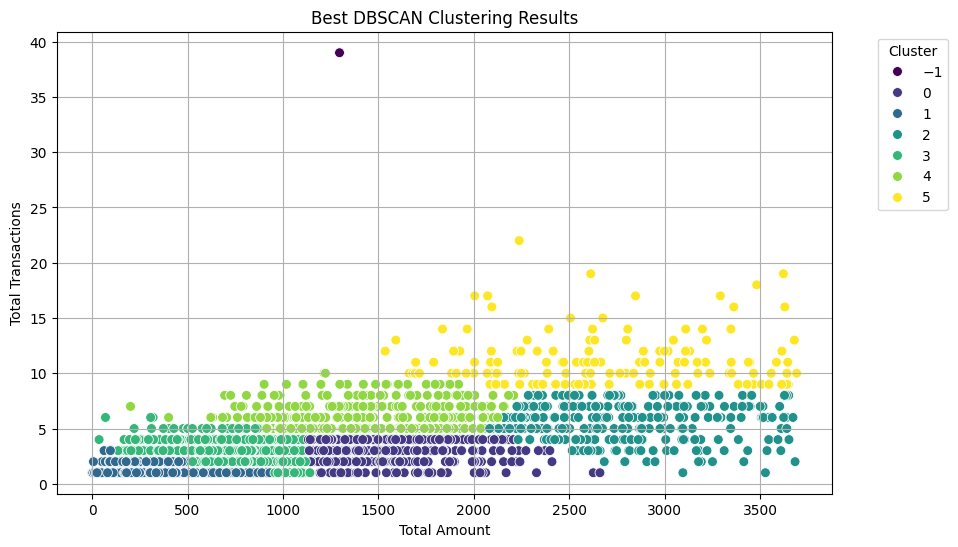

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Step 8: Data Scaling using Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = minmax_scaler.fit_transform(df_segmentation)
df_minmax_scaled = pd.DataFrame(df_minmax_scaled, columns=df_segmentation.columns)

# Define parameter grid for DBSCAN
eps_values = np.arange(0.1, 1.1, 0.1)  # Varying eps from 0.1 to 1.0
min_samples_values = [3, 5, 7, 10]      # Different min_samples values
param_grid = {"eps": eps_values, "min_samples": min_samples_values}

# Initialize results list
grid_search_results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    eps = params["eps"]
    min_samples = params["min_samples"]

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(df_minmax_scaled)

    # Count number of clusters (excluding noise points -1)
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    # Compute silhouette score if there are at least 2 clusters
    if num_clusters > 1:
        silhouette_avg = silhouette_score(df_minmax_scaled, clusters)
    else:
        silhouette_avg = "N/A (Only one cluster detected)"

    # Store results
    grid_search_results.append({
        "eps": eps,
        "min_samples": min_samples,
        "num_clusters": num_clusters,
        "silhouette_score": silhouette_avg
    })

# Convert results to DataFrame
grid_search_df = pd.DataFrame(grid_search_results)

# Find the best parameter combination (highest silhouette score)
best_params = grid_search_df[grid_search_df["silhouette_score"] != "N/A (Only one cluster detected)"]
if not best_params.empty:
    best_params = best_params.loc[best_params["silhouette_score"].idxmax()]
    print("Best DBSCAN Parameters:", best_params)

    # Apply DBSCAN with the best parameters
    best_dbscan = DBSCAN(eps=best_params["eps"], min_samples=best_params["min_samples"])
    df_segmentation["Cluster"] = best_dbscan.fit_predict(df_minmax_scaled)

    # Visualize the best clustering results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df_segmentation["TotalAmount"],
        y=df_segmentation["TotalTransactions"],
        hue=df_segmentation["Cluster"],
        palette="viridis",
        s=50
    )
    plt.xlabel("Total Amount")
    plt.ylabel("Total Transactions")
    plt.title("Best DBSCAN Clustering Results")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()
else:
    print("No valid clustering results found. Try adjusting eps and min_samples values.")

<a name="ex_6"></a>
# Exercise 6: Adjust K-Means Parameters

- Experiment with different values of n_clusters (other than 6) to see how they affect the segmentation. You can also adjust other parameters like init, n_init, or max_iter to observe their impact.
- Use silhouette scores to evaluate the segmentation quality for different numbers of clusters or parameter settings. Compare these scores to determine which configuration seems to have the best balance between cluster cohesion and separation.
- Summarize how changes in the number of clusters or other K-Means parameters impact the customer segmentation.

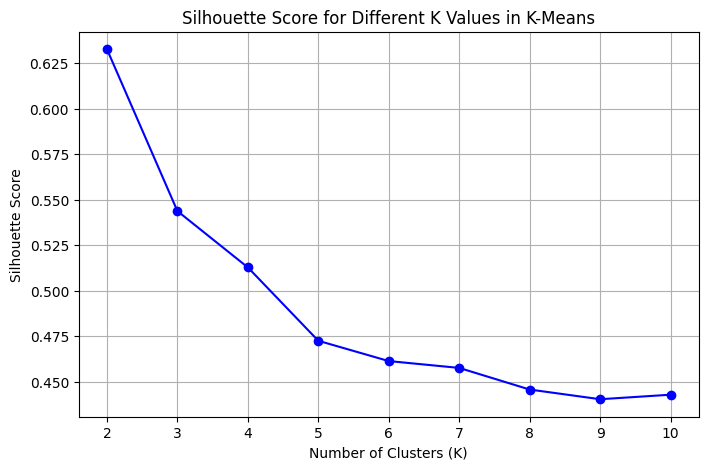

Best number of clusters based on Silhouette Score: 2


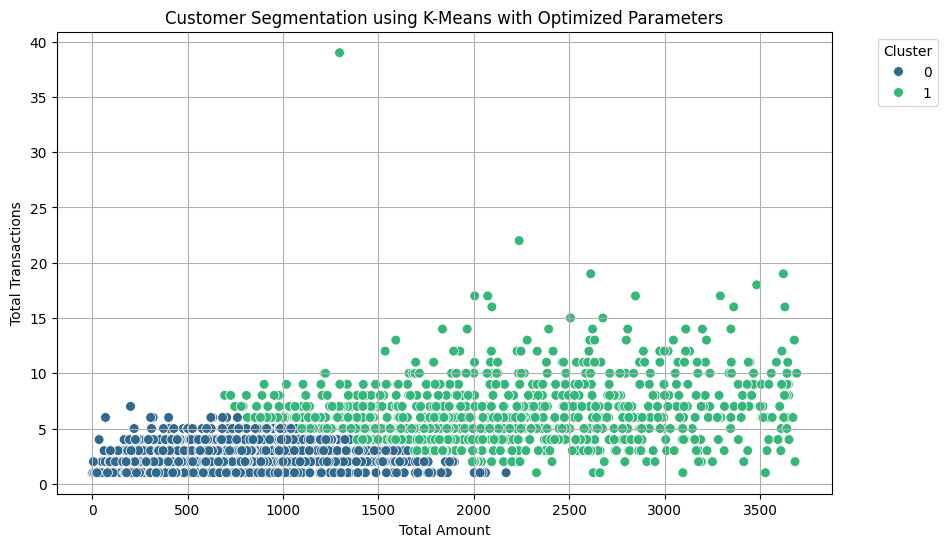

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 8: Data Scaling using Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = minmax_scaler.fit_transform(df_segmentation)
df_minmax_scaled = pd.DataFrame(df_minmax_scaled, columns=df_segmentation.columns)

# Define range for number of clusters
n_clusters_range = range(2, 11)

# Store results
kmeans_results = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    # Apply K-Means with different values of n_clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
    labels = kmeans.fit_predict(df_scaled)

    # Compute silhouette score
    silhouette_avg = silhouette_score(df_scaled, labels)
    silhouette_scores.append(silhouette_avg)

    # Store results
    kmeans_results.append({"n_clusters": n_clusters, "silhouette_score": silhouette_avg})

# Convert results to DataFrame
kmeans_results_df = pd.DataFrame(kmeans_results)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values in K-Means")
plt.grid(True)
plt.show()

# Find the best number of clusters (highest silhouette score)
best_n_clusters = kmeans_results_df.loc[kmeans_results_df["silhouette_score"].idxmax(), "n_clusters"]
print(f"Best number of clusters based on Silhouette Score: {best_n_clusters}")

# Apply K-Means with the best n_clusters
tuned_kmeans = KMeans(n_clusters=int(best_n_clusters), init='k-means++', n_init=10, max_iter=300, random_state=42)
df_segmentation["Cluster"] = tuned_kmeans.fit_predict(df_scaled)

# Visualize the clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_segmentation["TotalAmount"],
    y=df_segmentation["TotalTransactions"],
    hue=df_segmentation["Cluster"],
    palette="viridis",
    s=50
)
plt.xlabel("Total Amount")
plt.ylabel("Total Transactions")
plt.title("Customer Segmentation using K-Means with Optimized Parameters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()